In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Activation, Masking, Dropout,BatchNormalization, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler #to normalize data
from os.path import exists
import seaborn as sns
import datetime
from datetime import date
from tensorflow.keras import optimizers

In [2]:
df = pd.read_csv('LMT_5YR.csv',parse_dates=["Date"])
df_dividend=pd.read_csv('LMT_5YR_Dividend.csv',parse_dates=["Date"])

filter=df["Date"]>"1/1/2017"
df=df[filter]

filter=df_dividend["Date"]>"1/1/2017"
df_dividend=df_dividend[filter]

print("Dividend Count",len(df_dividend))

df=pd.merge(df,df_dividend,on="Date",how="left").fillna(0)
print(df[df["Dividends"]>0].head(10))
df.set_index("Date",inplace=True)

df['Year']=df.index.to_period('Y')

print(df['Year'].head(5))



Dividend Count 22
          Date        Open        High         Low       Close   Adj Close  \
37  2017-02-27  265.000000  270.000000  264.200012  269.359985  234.698196   
101 2017-05-30  281.829987  282.839996  279.730011  280.089996  245.623474   
166 2017-08-30  306.420013  307.220001  305.500000  306.299988  270.204102   
230 2017-11-30  319.619995  320.940002  318.480011  319.119995  283.279633   
290 2018-02-28  357.359985  359.200012  352.420013  352.440002  314.614227   
354 2018-05-31  319.239990  320.279999  314.470001  314.540009  282.542053   
419 2018-08-31  318.559998  320.890015  317.010010  320.410004  289.614624   
482 2018-11-30  300.750000  303.529999  297.880005  300.429993  273.544861   
541 2019-02-28  307.440002  311.750000  306.119995  309.410004  283.750824   
605 2019-05-31  337.589996  341.140015  337.489990  338.540009  312.475403   

      Volume  Dividends  
37   1499700       1.82  
101   902200       1.82  
166  1273000       1.82  
230  2626200       

In [3]:
print("We will invest $1000 in lmt")
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
#df = df.reset_index()

#get the first open price
first_date=df.index.min()
investment=1000
shares=float(investment)/float(df[df.index==first_date]["Open"])
print("Initial Share count",shares)
df['open_accum'] = (df[['Open']].pct_change()+1).cumprod()
df['open_accum']=df['open_accum'].astype(float)
df['open_accum']=df['open_accum'].mul(investment)
df['open_accum']=df['open_accum']+df['Dividends']*shares
df['open_accum']=df['open_accum'].fillna(0)
df['open_pct_change']=df['Open'].pct_change()

#filter=df["Open"]==0
#df.drop(df[filter].index, inplace = True)

print(df.shape)



We will invest $1000 in lmt
Initial Share count 3.98089176728772
(1414, 10)


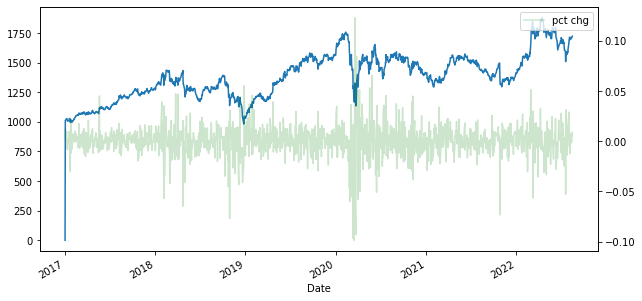

In [4]:
fig,ax = plt.subplots(figsize=(10,5)) 

df['open_accum'].plot(ax=ax,label="accumulation")
twinx=ax.twinx()
df['open_pct_change'].plot(ax=twinx,c='g',alpha=0.2,label="pct chg")
plt.legend()
plt.show()

          Date  Dividends
131 2017-02-27       1.82
132 2017-05-30       1.82
133 2017-08-30       1.82
134 2017-11-30       2.00
135 2018-02-28       2.00
136 2018-05-31       2.00
137 2018-08-31       2.00
138 2018-11-30       2.20
139 2019-02-28       2.20
140 2019-05-31       2.20


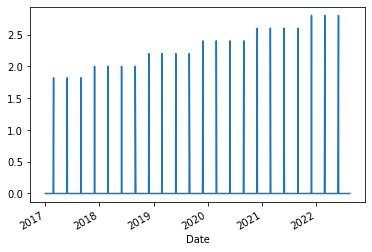

In [5]:
df["Dividends"].plot()
print(df_dividend.head(10))

1414


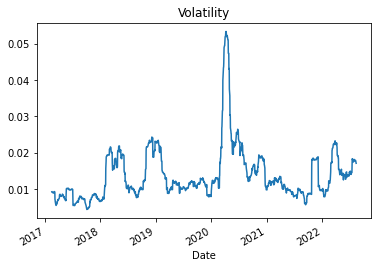

In [6]:
print(len(df))
rolling=df['open_pct_change'].rolling(30)
volatility=rolling.std().dropna()
volatility.plot()
plt.title("Volatility")
plt.show()

In [7]:
df["open_pct_positive_count"]=0

#######caculate the occurrences of positive open
for index in range(len(df)):
    count=0
    for index2 in (range(index,0,-1)):
        if df.iloc[index2]["open_pct_change"]>0:
            count=count+1
        else:
            break
    df.iloc[index, df.columns.get_loc('open_pct_positive_count')]=count
    
print(df[df["open_pct_positive_count"]>0])    


df["buy_count"]=0

for index in range(len(df)):
    count=0
    for index2 in (range(index,0,-1)):
        if df.iloc[index2]["open_pct_change"]>0:
            count=count+1
        else:
            break
    df.iloc[index, df.columns.get_loc('buy_count')]=count
    
df['action']=[ 'Sell' if x['buy_count']==0 else 'Buy' if x['buy_count']==2 else 'Hold' if x['buy_count'] > 2 else 'No Action' for key,x in df.iterrows()]
                
df["target"]=0
for index in range(len(df)):
    action=df.iloc[index]["action"]
    if (action=='Buy'):
             df.iloc[index, df.columns.get_loc('target')]=1
    elif (action=='Sell'):
             df.iloc[index, df.columns.get_loc('target')]=2
        
buy_list=df[df["target"]==1]
for index,item in buy_list.iterrows():
    print(index,item["Open"],item["open_pct_positive_count"])
    
print("buy count is when pct chg is postive for more than two consecutive days")

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2017-01-04  254.100006  254.899994  253.339996  253.990005  219.791855   
2017-01-05  254.369995  258.019989  254.100006  255.979996  221.513901   
2017-01-06  255.479996  258.570007  255.479996  257.850006  223.132172   
2017-01-09  258.000000  258.989990  257.429993  257.809998  223.097534   
2017-01-10  258.160004  258.959991  256.170013  256.170013  221.678345   
...                ...         ...         ...         ...         ...   
2022-08-03  427.269989  431.760010  419.640015  429.299988  429.299988   
2022-08-04  430.709991  434.649994  426.890015  428.130005  428.130005   
2022-08-08  427.500000  429.369995  421.679993  423.859985  423.859985   
2022-08-10  430.070007  432.250000  426.339996  429.989990  429.989990   
2022-08-15  432.679993  439.970001  429.859985  438.010010  438.010010   

             Volume  Dividends  Year 

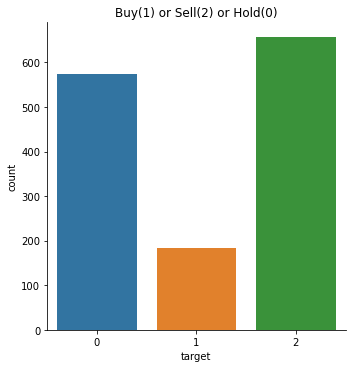

You want to find a stock where Hold counts are high


In [8]:
g=sns.catplot(x="target",data=df,kind="count")  #buy
plt.title('Buy(1) or Sell(2) or Hold(0)')
plt.show()

print('You want to find a stock where Hold counts are high')

    open_pct_positive_count  Incidence  Size
0                         0        2.0   657
1                         1        0.0   359
2                         2        1.0   184
3                         3        0.0   103
4                         4        0.0    53
5                         5        0.0    32
6                         6        0.0    14
7                         7        0.0     7
8                         8        0.0     2
9                         9        0.0     1
10                       10        0.0     1
11                       11        0.0     1
103
incidence show the average target value for each group


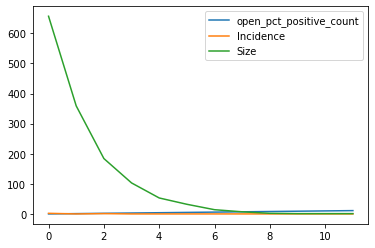

In [9]:
def create_pig_table(basetable, target, variable):
  
    # Create groups for each variable
    groups = basetable[[target,variable]].groupby(variable)
    
    pig_table=groups[target].agg([np.mean, np.size]).reset_index()
    pig_table=pig_table.rename(columns={'mean':'Incidence','size':'Size'})
    #pig_table = groups[target].agg({'Incidence' : np.mean, 'Size' : np.size}).reset_index()

    # Return the predictor insight graph table
    return pig_table

# Calculate the predictor insight graph table for the variable gender
pig_table = create_pig_table(df, "target", "open_pct_positive_count")
print(pig_table)
print(len(df[df['open_pct_positive_count']==3]))

print("incidence show the average target value for each group")

pig_table.plot()
plt.show()

In [24]:
def gen_train(id_df, seq_length, seq_cols):
    """
        function to prepare train data into (samples, time steps, features)
        id_df = train dataframe
        seq_length = look back period
        seq_cols = feature columns
    """
        
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        #lstm_array.append(np.nan_to_num(data_array[start:stop, :]))
        lstm_array.append(data_array[start:stop, :])
        #print(lstm_array)
    
    return np.array(lstm_array)

def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]

#print(df.columns)
#X_Columns = [column for column in df.columns if column not in["open_accum","Year"]]
#X_Columns=['Open', 'Volume',
#       'open_accum', 'open_pct_change', 'open_pct_positive_count',
#       'buy_count']
#print(X_Columns)
X_Columns=['Open', 'open_pct_positive_count', 'buy_count']
#
min_max_scaler = MinMaxScaler(feature_range=(-1,1))

#df[X_Columns] = min_max_scaler.fit_transform(df[X_Columns])

sequence_length=50

#[print(df[df['YearQuarter']==year_quarter]) for year_quarter in df['YearQuarter'].unique()]

X_train=np.concatenate(list(list(gen_train(df[df['Year']==year], sequence_length, X_Columns)) for year in df['Year'].unique()))
print("X_train",X_train.shape)
y_train = np.concatenate(list(list(gen_target(df[df['Year']==year], sequence_length, "open_accum")) for year in df['Year'].unique()))
print("y_train",y_train.shape)

X_train (1120, 50, 3)
y_train (1120,)


In [39]:
nb_features = X_train.shape[2]

model = Sequential()
model.add(LSTM(
         units=128,
         return_sequences=True,
         input_shape=(sequence_length, nb_features)))
model.add(BatchNormalization())
model.add(Dropout(0.02))
#model.add(Dense(units=256, activation="relu"))
model.add(LSTM(          units=128,          return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.02))
#model.add(Dense(units=50, activation="relu"))
model.add(Dense(units=1,activation='linear'))
#model.add(Dense(units=1, activation='relu'))
optimizer = optimizers.Adam()
model.compile(loss='mean_absolute_error',metrics=['accuracy'], optimizer=optimizer)

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 50, 128)           67584     
                                                                 
 batch_normalization_16 (Bat  (None, 50, 128)          512       
 chNormalization)                                                
                                                                 
 dropout_16 (Dropout)        (None, 50, 128)           0         
                                                                 
 lstm_17 (LSTM)              (None, 128)               131584    
                                                                 
 batch_normalization_17 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_17 (Dropout)        (None, 128)              

In [40]:

print ("Train the model")
length=len(X_train)
path_to_file="C:\\Users\\dnishimoto\\python_files\\python-deep-learning-master\\lstm_lmt_model.h5"

file_exists = exists(path_to_file)
if(file_exists):
    model.load_weights(path_to_file)
    
#history=model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=1,
#          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])

history=model.fit(X_train, y_train, epochs=1000, batch_size=32)


model.save_weights(path_to_file)


Train the model
Epoch 1/1000
35/35 [==============================] - 7s 92ms/step - loss: 1354.0029 - accuracy: 0.0000e+00
Epoch 2/1000
35/35 [==============================] - 3s 93ms/step - loss: 1348.5951 - accuracy: 0.0000e+00
Epoch 3/1000
35/35 [==============================] - 3s 86ms/step - loss: 1342.7358 - accuracy: 0.0000e+00
Epoch 4/1000
35/35 [==============================] - 3s 84ms/step - loss: 1336.3770 - accuracy: 0.0000e+00
Epoch 5/1000
35/35 [==============================] - 3s 86ms/step - loss: 1329.4905 - accuracy: 0.0000e+00
Epoch 6/1000
35/35 [==============================] - 3s 82ms/step - loss: 1321.9941 - accuracy: 0.0000e+00
Epoch 7/1000
35/35 [==============================] - 3s 84ms/step - loss: 1314.0393 - accuracy: 0.0000e+00
Epoch 8/1000
35/35 [==============================] - 3s 82ms/step - loss: 1305.4330 - accuracy: 0.0000e+00
Epoch 9/1000
35/35 [==============================] - 3s 82ms/step - loss: 1296.2754 - accuracy: 0.0000e+00
Epoch 10/100

35/35 [==============================] - 3s 79ms/step - loss: 34.2095 - accuracy: 0.0000e+00
Epoch 153/1000
35/35 [==============================] - 3s 83ms/step - loss: 29.8275 - accuracy: 0.0000e+00
Epoch 154/1000
35/35 [==============================] - 3s 83ms/step - loss: 36.3668 - accuracy: 0.0000e+00
Epoch 155/1000
35/35 [==============================] - 3s 81ms/step - loss: 28.9241 - accuracy: 0.0000e+00
Epoch 156/1000
35/35 [==============================] - 3s 80ms/step - loss: 38.5568 - accuracy: 0.0000e+00
Epoch 157/1000
35/35 [==============================] - 3s 88ms/step - loss: 32.4924 - accuracy: 0.0000e+00
Epoch 158/1000
35/35 [==============================] - 3s 77ms/step - loss: 36.3829 - accuracy: 0.0000e+00
Epoch 159/1000
35/35 [==============================] - 3s 86ms/step - loss: 32.4630 - accuracy: 0.0000e+00
Epoch 160/1000
35/35 [==============================] - 3s 76ms/step - loss: 30.6546 - accuracy: 0.0000e+00
Epoch 161/1000
35/35 [=====================

Epoch 228/1000
35/35 [==============================] - 3s 82ms/step - loss: 32.7002 - accuracy: 0.0000e+00
Epoch 229/1000
35/35 [==============================] - 3s 79ms/step - loss: 29.7270 - accuracy: 0.0000e+00
Epoch 230/1000
35/35 [==============================] - 3s 79ms/step - loss: 30.4353 - accuracy: 0.0000e+00
Epoch 231/1000
35/35 [==============================] - 3s 82ms/step - loss: 29.0318 - accuracy: 0.0000e+00
Epoch 232/1000
35/35 [==============================] - 3s 79ms/step - loss: 34.1924 - accuracy: 0.0000e+00
Epoch 233/1000
35/35 [==============================] - 3s 78ms/step - loss: 29.1841 - accuracy: 0.0000e+00
Epoch 234/1000
35/35 [==============================] - 3s 77ms/step - loss: 30.4353 - accuracy: 0.0000e+00
Epoch 235/1000
35/35 [==============================] - 3s 79ms/step - loss: 30.3377 - accuracy: 0.0000e+00
Epoch 236/1000
35/35 [==============================] - 3s 82ms/step - loss: 28.8699 - accuracy: 0.0000e+00
Epoch 237/1000
35/35 [======

Epoch 379/1000
35/35 [==============================] - 2s 71ms/step - loss: 30.7043 - accuracy: 0.0000e+00
Epoch 380/1000
35/35 [==============================] - 3s 72ms/step - loss: 31.3216 - accuracy: 0.0000e+00
Epoch 381/1000
35/35 [==============================] - 3s 72ms/step - loss: 29.9691 - accuracy: 0.0000e+00
Epoch 382/1000
35/35 [==============================] - 2s 71ms/step - loss: 32.5425 - accuracy: 0.0000e+00
Epoch 383/1000
35/35 [==============================] - 3s 72ms/step - loss: 30.2248 - accuracy: 0.0000e+00
Epoch 384/1000
35/35 [==============================] - 3s 72ms/step - loss: 29.6506 - accuracy: 0.0000e+00
Epoch 385/1000
35/35 [==============================] - 3s 72ms/step - loss: 33.8607 - accuracy: 0.0000e+00
Epoch 386/1000
35/35 [==============================] - 2s 71ms/step - loss: 31.2257 - accuracy: 0.0000e+00
Epoch 387/1000
35/35 [==============================] - 3s 73ms/step - loss: 28.5600 - accuracy: 0.0000e+00
Epoch 388/1000
35/35 [======

Epoch 530/1000
35/35 [==============================] - 3s 73ms/step - loss: 31.8927 - accuracy: 0.0000e+00
Epoch 531/1000
35/35 [==============================] - 3s 74ms/step - loss: 28.9632 - accuracy: 0.0000e+00
Epoch 532/1000
35/35 [==============================] - 2s 67ms/step - loss: 33.7366 - accuracy: 0.0000e+00
Epoch 533/1000
35/35 [==============================] - 3s 71ms/step - loss: 32.7605 - accuracy: 0.0000e+00
Epoch 534/1000
35/35 [==============================] - 2s 71ms/step - loss: 31.6430 - accuracy: 0.0000e+00
Epoch 535/1000
35/35 [==============================] - 2s 69ms/step - loss: 32.6972 - accuracy: 0.0000e+00
Epoch 536/1000
35/35 [==============================] - 3s 76ms/step - loss: 31.4859 - accuracy: 0.0000e+00
Epoch 537/1000
35/35 [==============================] - 2s 69ms/step - loss: 30.8051 - accuracy: 0.0000e+00
Epoch 538/1000
35/35 [==============================] - 2s 71ms/step - loss: 31.5694 - accuracy: 0.0000e+00
Epoch 539/1000
35/35 [======

Epoch 681/1000
35/35 [==============================] - 3s 76ms/step - loss: 29.6092 - accuracy: 0.0000e+00
Epoch 682/1000
35/35 [==============================] - 2s 70ms/step - loss: 30.2864 - accuracy: 0.0000e+00
Epoch 683/1000
35/35 [==============================] - 2s 70ms/step - loss: 31.7802 - accuracy: 0.0000e+00
Epoch 684/1000
35/35 [==============================] - 2s 70ms/step - loss: 33.2390 - accuracy: 0.0000e+00
Epoch 685/1000
35/35 [==============================] - 3s 78ms/step - loss: 28.5924 - accuracy: 0.0000e+00
Epoch 686/1000
35/35 [==============================] - 2s 71ms/step - loss: 32.7903 - accuracy: 0.0000e+00
Epoch 687/1000
35/35 [==============================] - 2s 69ms/step - loss: 30.6516 - accuracy: 0.0000e+00
Epoch 688/1000
35/35 [==============================] - 2s 70ms/step - loss: 28.3111 - accuracy: 0.0000e+00
Epoch 689/1000
35/35 [==============================] - 3s 73ms/step - loss: 28.1103 - accuracy: 0.0000e+00
Epoch 690/1000
35/35 [======

Epoch 832/1000
35/35 [==============================] - 2s 71ms/step - loss: 29.2773 - accuracy: 0.0000e+00
Epoch 833/1000
35/35 [==============================] - 2s 70ms/step - loss: 30.2717 - accuracy: 0.0000e+00
Epoch 834/1000
35/35 [==============================] - 2s 70ms/step - loss: 27.0828 - accuracy: 0.0000e+00
Epoch 835/1000
35/35 [==============================] - 3s 72ms/step - loss: 29.7530 - accuracy: 0.0000e+00
Epoch 836/1000
35/35 [==============================] - 3s 77ms/step - loss: 29.2720 - accuracy: 0.0000e+00
Epoch 837/1000
35/35 [==============================] - 3s 75ms/step - loss: 32.9430 - accuracy: 0.0000e+00
Epoch 838/1000
35/35 [==============================] - 3s 72ms/step - loss: 28.0621 - accuracy: 0.0000e+00
Epoch 839/1000
35/35 [==============================] - 3s 72ms/step - loss: 30.0177 - accuracy: 0.0000e+00
Epoch 840/1000
35/35 [==============================] - 3s 79ms/step - loss: 27.0354 - accuracy: 0.0000e+00
Epoch 841/1000
35/35 [======

Epoch 983/1000
35/35 [==============================] - 2s 70ms/step - loss: 32.5669 - accuracy: 0.0000e+00
Epoch 984/1000
35/35 [==============================] - 3s 72ms/step - loss: 30.6356 - accuracy: 0.0000e+00
Epoch 985/1000
35/35 [==============================] - 2s 71ms/step - loss: 29.3005 - accuracy: 0.0000e+00
Epoch 986/1000
35/35 [==============================] - 3s 76ms/step - loss: 30.9946 - accuracy: 0.0000e+00
Epoch 987/1000
35/35 [==============================] - 3s 73ms/step - loss: 29.8170 - accuracy: 0.0000e+00
Epoch 988/1000
35/35 [==============================] - 3s 73ms/step - loss: 31.1670 - accuracy: 0.0000e+00
Epoch 989/1000
35/35 [==============================] - 3s 77ms/step - loss: 35.2609 - accuracy: 0.0000e+00
Epoch 990/1000
35/35 [==============================] - 3s 73ms/step - loss: 35.4445 - accuracy: 0.0000e+00
Epoch 991/1000
35/35 [==============================] - 3s 72ms/step - loss: 30.9677 - accuracy: 0.0000e+00
Epoch 992/1000
35/35 [======

In [4]:
plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_mean_squared_error'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('# Epoch')
plt.legend(['train'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [46]:
scores = model.evaluate(X_train, y_train, verbose=1, batch_size=200)
print('MSE: {}'.format(scores[1]))

6/6 [==============================] - 1s 129ms/step - loss: 63.4932 - accuracy: 0.0000e+00
MSE: 0.0


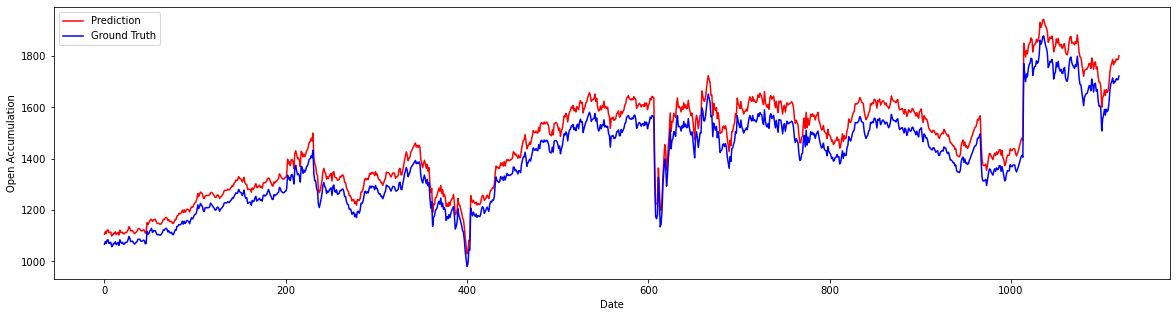

In [48]:
y_pred_test = model.predict(X_train, verbose=0)

plt.figure(figsize=(20,5))
plt.plot(y_pred_test, color='red', label='Prediction')
plt.plot(y_train, color='blue', label='Ground Truth')
plt.ylabel("Open Accumulation")
plt.xlabel("Date")
plt.legend(loc='upper left')
plt.show()

In [49]:
print("done!")

done!
